In [ ]:
# Simulation de pompage dans un puits pétrolier
# Écoulement monophasique, perte de charge, profils pression/debit
# Bibliothèques: numpy, scipy, matplotlib

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -----------------------------
# Paramètres physiques
# -----------------------------
L = 3000.0        # profondeur du puits (m)
D = 0.1           # diamètre interne du tubing (m)
rho = 850.0       # densité du pétrole (kg/m3)
mu = 0.02         # viscosité dynamique (Pa.s)
g = 9.81          # gravité (m/s2)

# Paramètres de pompage
Q = 0.02          # débit volumique (m3/s)

# Rugosité (acier)
epsilon = 4.5e-5  # m

# -----------------------------
# Fonctions utiles
# -----------------------------

def reynolds(rho, v, D, mu):
    return rho * v * D / mu


def friction_factor(Re, eps, D):
    """Facteur de frottement de Darcy (approx. Swamee-Jain)"""
    if Re < 2000:
        return 64.0 / Re
    return 0.25 / (np.log10(eps/(3.7*D) + 5.74/(Re**0.9)))**2


# -----------------------------
# Calcul vitesse et Reynolds
# -----------------------------
A = np.pi * D**2 / 4
v = Q / A
Re = reynolds(rho, v, D, mu)
f = friction_factor(Re, epsilon, D)

# -----------------------------
# Équation différentielle pression
# dP/dz = rho*g + pertes de charge
# -----------------------------

def dP_dz(z, P):
    dp_grav = rho * g
    dp_fric = f * (rho * v**2) / (2 * D)
    return dp_grav + dp_fric

# Intégration le long du puits
z_span = (0, L)
z_eval = np.linspace(0, L, 200)
P0 = [1e5]  # pression en tête de puits (Pa)

sol = solve_ivp(dP_dz, z_span, P0, t_eval=z_eval)

z = sol.t
P = sol.y[0]

# -----------------------------
# Profils débit / pression
# -----------------------------
Q_profile = np.ones_like(z) * Q

# -----------------------------
# Tracés
# -----------------------------
plt.style.use('dark_background')
plt.figure()
plt.plot(P/1e5, z, color='white', linewidth=2)
plt.gca().invert_yaxis()
plt.xlabel("Pression (bar)")
plt.ylabel("Profondeur (m)")
plt.title("Profil de pression dans le puits")
plt.grid()

plt.figure()
plt.plot(Q_profile*3600, z, color='red', linewidth=2)
plt.gca().invert_yaxis()
plt.xlabel("Débit (m3/h)")
plt.ylabel("Profondeur (m)")
plt.title("Profil de débit (constant)")
plt.grid()

plt.show()


# Résultats principaux

print("===== RÉSULTATS =====")
print(f"Vitesse moyenne: {v:.2f} m/s")
print(f"Reynolds: {Re:.2e}")
print(f"Facteur de frottement: {f:.4f}")
print(f"Pression fond de puits: {P[-1]/1e5:.2f} bar")


Using column 'Production_flow_m3s' for base production flow.


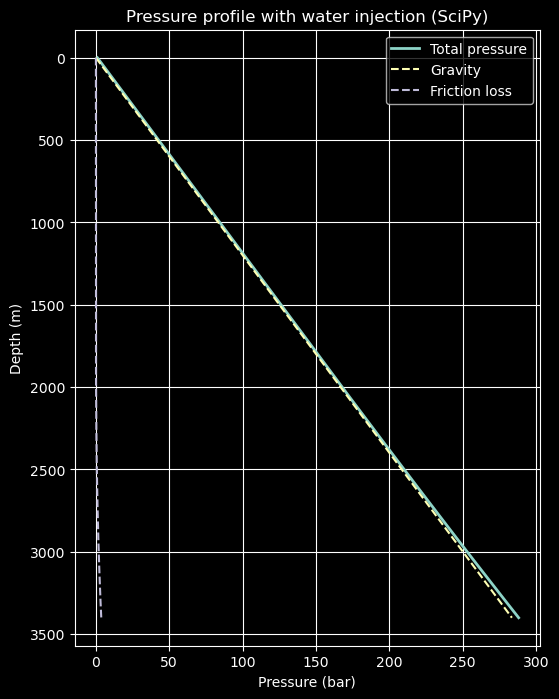

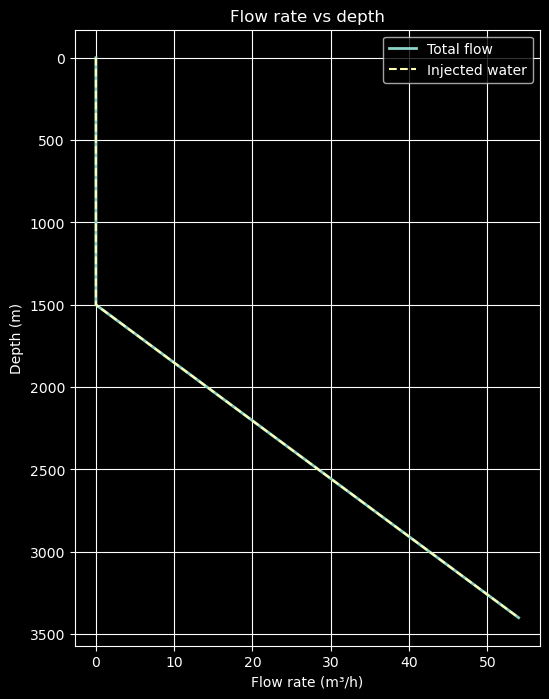

===== RESULTS =====
Bottom-hole pressure: 288.11 bar
Friction pressure loss: 3.64 bar
Max injected water: 54.00 m3/h


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp   # ✅ SciPy added

# -----------------------------
# Physical parameters
# -----------------------------
rho = 850.0          # kg/m3
mu = 0.02            # Pa.s
D = 0.1              # m
g = 9.81
epsilon = 4.5e-5

A = np.pi * D**2 / 4
P_wh = 1e5           # wellhead pressure (Pa)

# -----------------------------
# Load data
# -----------------------------
data = pd.read_csv("Sakidata.csv")
z_data = data["Depth_m"].values

# Base production flow (m3/s)
# Try known column then fallback to heuristics to avoid KeyError
if "Liquid_volume_m3_day" in data.columns:
    Q_prod = data["Liquid_volume_m3_day"].values[0] / 86400.0
else:
    # search for likely column names (case-insensitive)
    candidates = [c for c in data.columns
                  if ("liquid" in c.lower()) or ("volume" in c.lower()) or ("m3" in c.lower() and "day" in c.lower())]
    if candidates:
        col = candidates[0]
    else:
        # fallback: first numeric column excluding depth
        numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        numeric_cols = [c for c in numeric_cols if c != "Depth_m"]
        if numeric_cols:
            col = numeric_cols[0]
        else:
            raise KeyError("Column 'Liquid_volume_m3_day' not found and no suitable numeric column in CSV.")
    print(f"Using column '{col}' for base production flow.")
    Q_prod = data[col].values[0] / 86400.0

# -----------------------------
# Water injection model
# -----------------------------
inj_start = 1500.0      # m
Q_inj_max = 0.015       # m3/s

def Q_total_of_z(z):
    if z < inj_start:
        return Q_prod
    return Q_prod + Q_inj_max * (z - inj_start) / (z_data.max() - inj_start)

# -----------------------------
# Flow physics
# -----------------------------
def friction_factor(Re, eps, D):
    if Re < 2000:
        return 64.0 / Re
    return 0.25 / (np.log10(eps/(3.7*D) + 5.74/(Re**0.9)))**2

# -----------------------------
# Pressure ODE (SciPy)
# -----------------------------
def dP_dz(z, P):
    Q = Q_total_of_z(z)
    v = Q / A

    Re = rho * v * D / mu
    f = friction_factor(Re, epsilon, D)

    dpdz_grav = rho * g
    dpdz_fric = f * (rho * v**2) / (2 * D)

    return dpdz_grav + dpdz_fric

# -----------------------------
# Solve pressure equation
# -----------------------------
z_span = (z_data.min(), z_data.max())
P0 = [P_wh]

sol = solve_ivp(
    dP_dz,
    z_span,
    P0,
    t_eval=z_data,
    method="RK45"
)

P_total = sol.y[0]
z = sol.t

# -----------------------------
# Post-processing (friction only)
# -----------------------------
Q_vec = np.array([Q_total_of_z(zi) for zi in z])
v = Q_vec / A
Re = rho * v * D / mu

f = np.where(
    Re < 2000,
    64.0 / Re,
    0.25 / (np.log10(epsilon/(3.7*D) + 5.74/(Re**0.9)))**2
)

dpdz_fric = f * (rho * v**2) / (2 * D)
dp_fric = np.cumsum(dpdz_fric * np.gradient(z))

dp_grav = rho * g * z

# -----------------------------
# Save updated dataset (optional)
# -----------------------------
data["Injected_water_m3s"] = Q_vec - Q_prod
data["Total_flow_m3s"] = Q_vec
data["Pressure_friction_Pa"] = dp_fric
data["Pressure_total_Pa"] = P_total

# -----------------------------
# PLOT 1: Pressure vs Depth
# -----------------------------
plt.style.use("dark_background")

plt.figure(figsize=(6,8))
plt.plot(P_total/1e5, z, label="Total pressure", linewidth=2)
plt.plot(dp_grav/1e5, z, "--", label="Gravity")
plt.plot(dp_fric/1e5, z, "--", label="Friction loss")

plt.gca().invert_yaxis()
plt.xlabel("Pressure (bar)")
plt.ylabel("Depth (m)")
plt.title("Pressure profile with water injection (SciPy)")
plt.legend()
plt.grid()

# -----------------------------
# PLOT 2: Flow rate vs Depth
# -----------------------------
plt.figure(figsize=(6,8))
plt.plot(Q_vec*3600, z, label="Total flow", linewidth=2)
plt.plot((Q_vec - Q_prod)*3600, z, "--", label="Injected water")

plt.gca().invert_yaxis()
plt.xlabel("Flow rate (m³/h)")
plt.ylabel("Depth (m)")
plt.title("Flow rate vs depth")
plt.legend()
plt.grid()

plt.show()

# -----------------------------
# Results
# -----------------------------
print("===== RESULTS =====")
print(f"Bottom-hole pressure: {P_total[-1]/1e5:.2f} bar")
print(f"Friction pressure loss: {dp_fric[-1]/1e5:.2f} bar")
print(f"Max injected water: {(Q_vec.max()-Q_prod)*3600:.2f} m3/h")
